### GPT2 loading

In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch
from torch.utils.data import Dataset
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config
from datasets import load_dataset
import math
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm import tqdm


In [3]:

model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

next-token prediction , since we are working with a decoder which is more suitable for generation taks

## Fine tuning bert

In [4]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"], 
        truncation=True, 
        padding="max_length", 
        max_length=128  # you can adjust
    )
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")


tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [6]:


class GPT2TextDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.encodings["input_ids"][idx])
        attention_mask = torch.tensor(self.encodings["attention_mask"][idx])
        labels = input_ids.clone()  # for causal LM, labels = input_ids
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

train_dataset = GPT2TextDataset(tokenized_datasets["train"].select(range(1000)))
val_dataset = GPT2TextDataset(tokenized_datasets["validation"].select(range(200)))


In [17]:
test_dataset = GPT2TextDataset(tokenized_datasets["test"].select(range(200)))


In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [18]:
test_loader = DataLoader(test_dataset, batch_size=32)

## model training

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accumulation_steps = 4

In [9]:
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [10]:
optimizer = Adam(model.parameters(), lr=5e-5)


In [15]:
epochs = 3
for epoch in range(epochs):
    model.train()
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    total_train_loss = 0

    for step,batch in enumerate(progress_bar):
        
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        if step % 100 == 0:  # Log every 100 steps
            progress_bar.set_postfix({'loss': loss.item()})

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}")

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            total_val_loss += outputs.loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f}")

Epoch 1:  62%|██████▎   | 20/32 [01:18<00:46,  3.90s/it, loss=7.33]Exception ignored in: <function _xla_gc_callback at 0x7ca9db1f6de0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 
Epoch 1: 100%|██████████| 32/32 [02:02<00:00,  3.82s/it, loss=7.33]


Epoch 1 | Train Loss: 1.8360
Epoch 1 | Val Loss: 1.4356


Epoch 2: 100%|██████████| 32/32 [02:01<00:00,  3.80s/it, loss=1.89]


Epoch 2 | Train Loss: 1.2828
Epoch 2 | Val Loss: 1.3842


Epoch 3: 100%|██████████| 32/32 [02:01<00:00,  3.79s/it, loss=1.03]


Epoch 3 | Train Loss: 1.1723
Epoch 3 | Val Loss: 1.3797


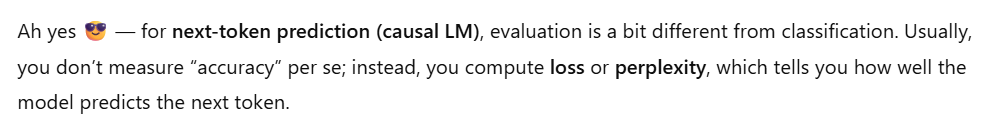

In [21]:
model.eval()
total_loss = 0
num_batches = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        total_loss += loss.item()
        num_batches += 1

avg_loss = total_loss / num_batches
perplexity = math.exp(avg_loss)

print(f"Validation Loss: {avg_loss:.4f}")
print(f"Validation Perplexity: {perplexity:.4f}")


Validation Loss: 1.3060
Validation Perplexity: 3.6916


In [23]:
torch.save(model.state_dict(),"gpt2_ntp.pth")